## Loading Data and creating hugging face dataset

In [1]:
! pip install datasets transformers
from datasets import load_dataset

In [2]:
#location of directory where images are stores. Change this folder location as per your need
location = '/home/kc/j1guestgs01/DL_project/labelled_folder'

In [3]:
#follow : https://huggingface.co/docs/datasets/loading
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir=location)

Resolving data files:   0%|          | 0/15339 [00:00<?, ?it/s]

Using custom data configuration default-e9a65c35975de60b


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /home/kc/j1guestgs01/.cache/huggingface/datasets/image_folder/default-e9a65c35975de60b/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15339
    })
})

This method is followed from the website: https://huggingface.co/blog/fine-tune-vit

## Split data into train, validation and test

We will use dataset.train_test_split() function from hugging face library. This split is only offered into 2 splits: train and test. 
So, we will do 2 splits here. Follow the codeblock below

In [5]:
from datasets import load_dataset, dataset_dict, DatasetDict

In [6]:
# 80% train, 20% test + validation
train_testvalid = dataset['train'].train_test_split(shuffle = True, seed = 200, test_size=0.2)
# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(shuffle = True, seed = 200, test_size=0.5)
# gather everyone to have a single DatasetDict
full_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [7]:
full_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12271
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1534
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 1534
    })
})

The variable **full_dataset** is a *DatasetDict* object which contain three json objects, namely, *train*,*valid*,*test*. 

  + image: It is PIL image. So you can visually see the image
  + label: A *datasets.ClassLabel* feature, which is an integer representation of the label.

In [8]:
ex = full_dataset['train'][6500]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F04904DFA90>,
 'label': 3}

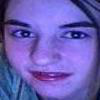

In [9]:
image = ex['image']
image

This girl is quite happy. :)

In [10]:
labels = full_dataset['train'].features['label']
labels

ClassLabel(num_classes=7, names=['1', '2', '3', '4', '5', '6', '7'], id=None)

##### Defining labels

Notes:
  + 1: Surprise
  + 2: Fear
  + 3: Disgust
  + 4: Happiness
  + 5: Sadness
  + 6: Anger
  + 7: Neutral

In [11]:
#Now, let's print out the class label for our example
labels.int2str(ex['label'])

'4'

### Data exploration 

Let's write a function that'll display a grid of examples from each class to get a better idea of what you're working with.

In [12]:
full_dataset['train'].features['label'].names

['1', '2', '3', '4', '5', '6', '7']

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

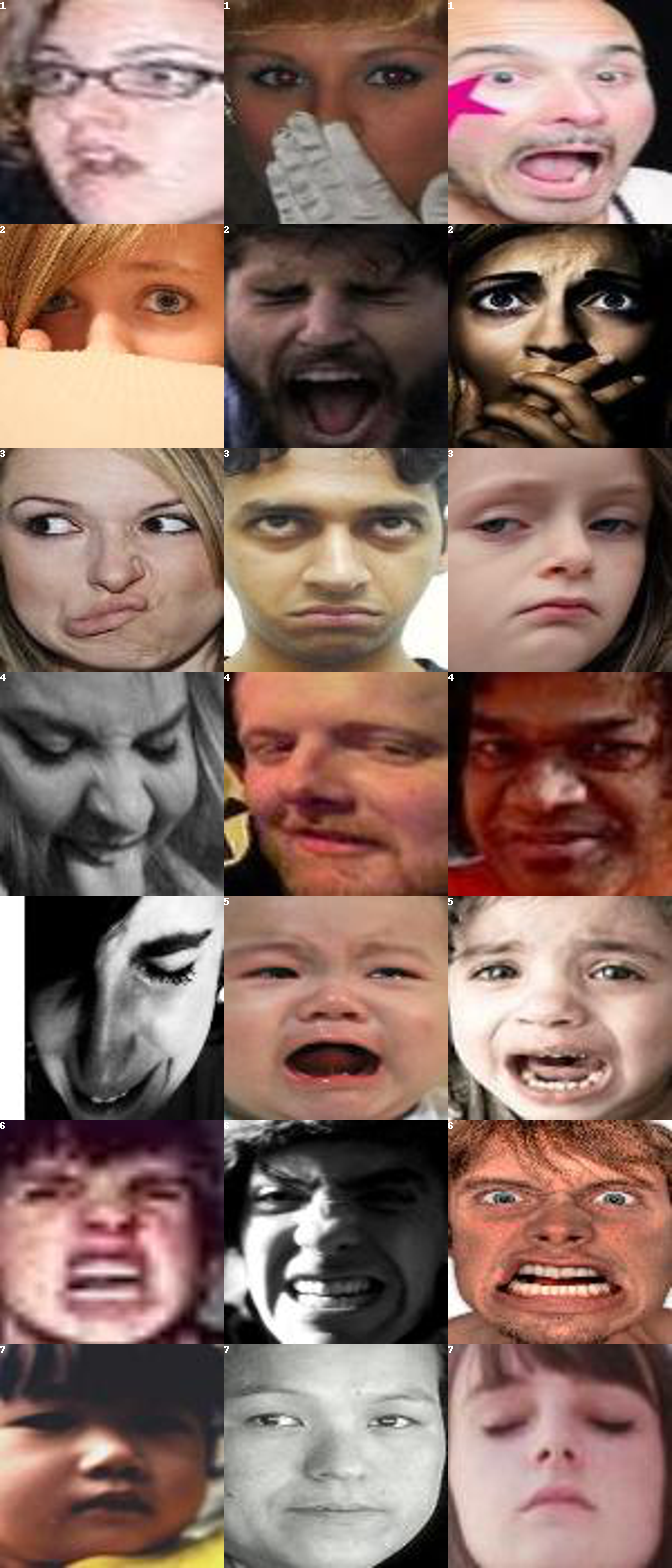

In [13]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(224, 224)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(full_dataset, seed=random.randint(0, 1337), examples_per_class=3)

From what I'm seeing,

  + 1: Surprise - Eyes are extra open with a subtle serious face
  + 2: Fear - The expression involves open eyes and mouth
  + 3: Disgust - The eyebrows pulled down, nose wrinkled, upper lip pulled up, lips loose.
  + 4: Happiness - I see muscle around the eyes are tightened, “crows feet” wrinkles around the eyes
  + 5: Sadness - I can see inner corners of eyebrows raised, lip corners pulled down
  + 6: Anger - The expression involves the eyebrows come down and together, the eyes glare, and there is a narrowing of the lip corners
  + 7: Neutral - nothing unsual expression is observed

### Loading ViT Feature Extractor

When ViT models are trained, specific transformations are applied to images fed into them. We will use a ViTFeatureExtractor initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the google/vit-base-patch16-224-in21k model, so let's load its feature extractor from the Hugging Face Hub.

In [14]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

You can see the *feature_extractor* configuration by printing it.

In [15]:
print(feature_extractor)

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



To process an image, simply pass it to the feature extractor's call function. This will return a dict containing *pixel values*, which is the numeric representation to be passed to the model.

You get a *NumPy* array by default, but if you add the *return_tensors='pt'* argument, you'll get back torch tensors instead.

In [16]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.8196, -0.8196, -0.8118,  ..., -0.7804, -0.7804, -0.7804],
          [-0.8118, -0.8118, -0.8118,  ..., -0.8039, -0.8118, -0.8118],
          [-0.8039, -0.8039, -0.8039,  ..., -0.8667, -0.8980, -0.9059],
          ...,
          [-0.4980, -0.5216, -0.5765,  ..., -0.9529, -0.9216, -0.9137],
          [-0.4667, -0.4902, -0.5686,  ..., -0.9529, -0.9216, -0.9059],
          [-0.4510, -0.4824, -0.5608,  ..., -0.9529, -0.9216, -0.9059]],

         [[-0.8980, -0.8980, -0.8902,  ..., -0.7804, -0.7804, -0.7804],
          [-0.8902, -0.8902, -0.8902,  ..., -0.8039, -0.8118, -0.8118],
          [-0.8824, -0.8824, -0.8824,  ..., -0.8667, -0.8980, -0.9059],
          ...,
          [-0.1608, -0.1843, -0.2392,  ..., -0.8980, -0.8667, -0.8510],
          [-0.1294, -0.1529, -0.2314,  ..., -0.8980, -0.8588, -0.8431],
          [-0.1137, -0.1451, -0.2235,  ..., -0.8980, -0.8588, -0.8431]],

         [[-0.7098, -0.7098, -0.7020,  ..., -0.5137, -0.5137, -0.5137],
          [-0

### Preprocessing the dataset

Now that you know how to read images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [17]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [18]:
process_example(full_dataset['train'][10])
#the shape of the tensor is (1, 3, 224, 224)

{'pixel_values': tensor([[[[ 0.7176,  0.7176,  0.7098,  ..., -0.1137, -0.1216, -0.1216],
          [ 0.7255,  0.7255,  0.7176,  ..., -0.1137, -0.1216, -0.1216],
          [ 0.7333,  0.7333,  0.7255,  ..., -0.1059, -0.1137, -0.1137],
          ...,
          [-0.7176, -0.7255, -0.7569,  ..., -0.7647, -0.7569, -0.7569],
          [-0.8275, -0.8196, -0.8118,  ..., -0.7647, -0.7569, -0.7569],
          [-0.8667, -0.8588, -0.8353,  ..., -0.7647, -0.7569, -0.7569]],

         [[ 0.1843,  0.1843,  0.1765,  ..., -0.6078, -0.6157, -0.6157],
          [ 0.1922,  0.1843,  0.1765,  ..., -0.6078, -0.6157, -0.6157],
          [ 0.2000,  0.1922,  0.1843,  ..., -0.6000, -0.6078, -0.6078],
          ...,
          [-0.8353, -0.8431, -0.8745,  ..., -0.9529, -0.9451, -0.9451],
          [-0.9451, -0.9373, -0.9294,  ..., -0.9529, -0.9451, -0.9451],
          [-0.9843, -0.9765, -0.9529,  ..., -0.9529, -0.9451, -0.9451]],

         [[ 0.1765,  0.1765,  0.1686,  ..., -0.6471, -0.6549, -0.6549],
          [ 0

We now apply a transform to the dataset. Transforms are only applied to examples as you index them.
First, though, you'll need to update the last function to accept a batch of data, as that's what *ds.with_transform* expects.

In [19]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [20]:
# You can directly apply this to the dataset using ds.with_transform(transform)
prepared_ds = full_dataset.with_transform(transform)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12271
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1534
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 1534
    })
})

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices, as shown below)

In [21]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.6706, -0.6784, -0.7020,  ..., -0.5373, -0.5451, -0.5529],
          [-0.6863, -0.6941, -0.7098,  ..., -0.5373, -0.5451, -0.5529],
          [-0.7176, -0.7255, -0.7412,  ..., -0.5373, -0.5451, -0.5451],
          ...,
          [-0.0196, -0.0275, -0.0353,  ...,  0.3490,  0.4118,  0.4353],
          [-0.0118, -0.0196, -0.0275,  ...,  0.3490,  0.4039,  0.4275],
          [-0.0118, -0.0196, -0.0275,  ...,  0.3490,  0.4039,  0.4275]],

         [[-0.6863, -0.6941, -0.7098,  ..., -0.5216, -0.5294, -0.5373],
          [-0.7020, -0.7098, -0.7255,  ..., -0.5216, -0.5294, -0.5373],
          [-0.7333, -0.7412, -0.7569,  ..., -0.5216, -0.5294, -0.5294],
          ...,
          [-0.3333, -0.3412, -0.3490,  ..., -0.0588, -0.0275, -0.0118],
          [-0.3255, -0.3333, -0.3412,  ..., -0.0588, -0.0275, -0.0196],
          [-0.3255, -0.3333, -0.3412,  ..., -0.0588, -0.0275, -0.0196]],

         [[-0.6784, -0.6863, -0.7098,  ..., -0.4039, -0.4118, -0.4196],
          [-0

This time, the resulting *pixel_values* tensor will have shape (2, 3, 224, 224).

### Training and Evaluation

The data is processed and you are ready to start setting up the training pipeline. This blog post uses 🤗's Trainer, but that'll require us to do a few things first:

  + Define a collate function.

  + Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. You should define a compute_metrics function accordingly.

  + Load a pretrained checkpoint. You need to load a pretrained checkpoint and configure it correctly for training.

  + Define the training configuration.

After fine-tuning the model, you will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify the images.

#### Define our data collator

Batches are coming in as lists of dicts, so you can just unpack + stack those into batch tensors.

Since the *collate_fn* will return a batch dict, you can **unpack the inputs to the model later. ✨

In [22]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

#### Define an evaluation metric

The *accuracy* metric from datasets can easily be used to compare the predictions with the labels. Below, you can see how to use it within a *compute_metrics* function that will be used by the Trainer.

In [23]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Let's load the pretrained model. We'll add *num_labels* on init so the model creates a classification head with the right number of units.

In [24]:
from transformers import ViTForImageClassification

labels = full_dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels)
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Almost ready to train! The last thing needed before that is to set up the training configuration by defining *TrainingArguments*.

Most of these are pretty self-explanatory, but one that is quite important here is *remove_unused_columns=False*. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-rafbd",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [26]:
! pip install tensorboardX

In [27]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["valid"],
    tokenizer=feature_extractor,
)

Using amp half precision backend


#### Train 🚀

In [28]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/kc/j1guestgs01/.conda/envs/labor_project/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12271
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3068


Step,Training Loss,Validation Loss,Accuracy
100,1.089100,0.983977,0.657106
200,0.914600,0.942166,0.666884
300,0.867800,0.868701,0.694263
400,0.829200,0.803616,0.728162
500,0.677900,0.712924,0.768579
600,0.750400,0.680918,0.767927
700,0.719000,0.661739,0.768579
800,0.520700,0.689377,0.764016
900,0.403900,0.651695,0.784224
1000,0.522300,0.576815,0.806389


***** Running Evaluation *****
  Num examples = 1534
  Batch size = 8
Saving model checkpoint to ./vit-base-rafbd/checkpoint-100
Configuration saved in ./vit-base-rafbd/checkpoint-100/config.json
Model weights saved in ./vit-base-rafbd/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-rafbd/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [vit-base-rafbd/checkpoint-400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1534
  Batch size = 8
Saving model checkpoint to ./vit-base-rafbd/checkpoint-200
Configuration saved in ./vit-base-rafbd/checkpoint-200/config.json
Model weights saved in ./vit-base-rafbd/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-rafbd/checkpoint-200/preprocessor_config.json
Deleting older checkpoint [vit-base-rafbd/checkpoint-600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1534
  Batch size = 8
Saving model checkpoint to ./vit-base-rafbd/checkp

Feature extractor saved in ./vit-base-rafbd/checkpoint-1900/preprocessor_config.json
Deleting older checkpoint [vit-base-rafbd/checkpoint-1800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1534
  Batch size = 8
Saving model checkpoint to ./vit-base-rafbd/checkpoint-2000
Configuration saved in ./vit-base-rafbd/checkpoint-2000/config.json
Model weights saved in ./vit-base-rafbd/checkpoint-2000/pytorch_model.bin
Feature extractor saved in ./vit-base-rafbd/checkpoint-2000/preprocessor_config.json
Deleting older checkpoint [vit-base-rafbd/checkpoint-1900] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1534
  Batch size = 8
Saving model checkpoint to ./vit-base-rafbd/checkpoint-2100
Configuration saved in ./vit-base-rafbd/checkpoint-2100/config.json
Model weights saved in ./vit-base-rafbd/checkpoint-2100/pytorch_model.bin
Feature extractor saved in ./vit-base-rafbd/checkpoint-2100/preprocessor_config.json
Deleting older checkpoint

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 3542552954GF
  train_loss               =       0.3984
  train_runtime            =   0:39:51.86
  train_samples_per_second =       20.521
  train_steps_per_second   =        1.283


#### Evaluate 📊

In [29]:
metrics = trainer.evaluate(prepared_ds['valid'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1534
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8259
  eval_loss               =     0.4967
  eval_runtime            = 0:00:24.39
  eval_samples_per_second =     62.881
  eval_steps_per_second   =       7.87


#### Test 📊

In [31]:
metrics = trainer.predict(prepared_ds['test'])
#trainer.log_metrics("test", metrics)
#trainer.save_metrics("test", metrics)

***** Running Prediction *****
  Num examples = 1534
  Batch size = 8


PredictionOutput(predictions=array([[-1.323 , -2.334 , -0.2347, ..., -0.2426, -0.6973,  4.2   ],
       [-3.076 , -1.52  ,  0.5127, ...,  3.115 ,  1.065 ,  0.857 ],
       [ 1.746 ,  4.082 , -0.7466, ..., -0.5205,  0.3298, -2.107 ],
       ...,
       [-3.074 , -2.422 , -0.63  , ..., -0.6133, -1.408 ,  1.523 ],
       [-2.104 , -2.568 , -0.3557, ...,  1.462 , -1.746 ,  3.873 ],
       [-0.2634,  0.801 , -0.3464, ..., -0.5874,  4.79  , -1.582 ]],
      dtype=float16), label_ids=array([6, 4, 1, ..., 3, 6, 5]), metrics={'test_loss': 0.5516098141670227, 'test_accuracy': 0.8207301173402868, 'test_runtime': 18.2874, 'test_samples_per_second': 83.883, 'test_steps_per_second': 10.499})

In [33]:
metrics.metrics

{'test_loss': 0.5516098141670227,
 'test_accuracy': 0.8207301173402868,
 'test_runtime': 18.2874,
 'test_samples_per_second': 83.883,
 'test_steps_per_second': 10.499}

The best accuracy we got on test data is 82.07%